# IU Difference: XGB Experiment based on 73 Variables 525k Rows 6 Waves

In [1]:
%pwd

'/mnt/f/ESG09_Project/Code'

In [2]:
%cd ..

/mnt/f/ESG09_Project


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Package

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from scipy import stats
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from xgboost import XGBClassifier, XGBRegressor

In [4]:
print(shap.__version__)

0.45.2.dev36


## Load and Make Datasets

In [5]:
Df_Filename = os.path.join("Data", "GallupWB_Zhang47var798k6wave_v1.parquet")

In [6]:
Df = pd.read_parquet(Df_Filename)

In [7]:
Df.shape

(798604, 74)

In [8]:
Df.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,Children_under15,Feeling_income,Born_here,Home_handline,Mobile_phone,Internet_access_available,Used_internet_recently,Phone_internet_access,COUNTRY_ISO3,Income_level
1709734,12,592300.098717,5.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,5.0
1709735,12,106614.017769,9.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709736,12,21322.803554,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,USA,3.0
1709737,12,56860.809477,5.0,0.0,1.0,1.0,-0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709738,12,33844.027641,7.0,1.0,1.0,1.0,-0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,2.0


In [9]:
Df.columns

Index(['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have',
       'Life_satisfaction', 'Living_standard_trend', 'Enough_food',
       'Enough_shelter', 'Well_rested', 'Respected', 'Smile',
       'Interesting_thing', 'Enjoyment', 'Physical_pain', 'Worry', 'Sadness',
       'Stress', 'Anger', 'City_satisfaction', 'Recommended_live_place',
       'Economic_rating', 'Economic_trend', 'Local_job_outlook',
       'Satisfied_pubtran', 'Satisfied_road', 'Satisfied_edu',
       'Satisfied_qualityair', 'Satisfied_qualitywater',
       'Satisfied_healthcare', 'Satisfied_affhouse', 'Satisfied_oppofriend',
       'Good_minorities', 'Good_homo', 'Good_immigrants', 'Donated',
       'Volunteer', 'Help_stranger', 'Voice_official',
       'Local_police_confidence', 'Safety_walk', 'Stolen', 'Assualted',
       'Religion_importance', 'Children_respected', 'Children_learn',
       'Women_respected', 'Satisfied_dealpoor', 'Satisfied_Env_preservation',
       'Satisfied_Personalfreedom

In [10]:


print(Df['Internet_access_available'].value_counts())

Internet_access_available
1.0    539754
0.0    258850
Name: count, dtype: int64


In [11]:
print(Df['Phone_internet_access'].value_counts())

Phone_internet_access
1.0    527859
0.0    270745
Name: count, dtype: int64


In [12]:

print(Df['Used_internet_recently'].value_counts())

Used_internet_recently
1.0    496245
0.0    302359
Name: count, dtype: int64


### Check the Difference with Internet Use

In [13]:
InternetAvailable_CantrilLadder= Df.loc[Df['Internet_access_available']==1, 'Cantril_ladder'].mean()

In [14]:
InternetAvailable_CantrilLadder

6.051217776987294

In [15]:
InternetUnavailable_CantrilLadder = Df.loc[Df['Internet_access_available']==0, 'Cantril_ladder'].mean()

In [16]:
InternetUnavailable_CantrilLadder

4.582418389028395

In [17]:
t_stat, p_value = stats.ttest_ind(Df.loc[Df['Internet_access_available']==1, 'Cantril_ladder'], Df.loc[Df['Internet_access_available']==0, 'Cantril_ladder'])

In [18]:
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 250.03071115917842, P-value: 0.0


### Shuffle Conversion

In [19]:
Df = Df.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
#Df = pd.get_dummies(Df, columns=['COUNTRY_ISO3'], prefix='COUNTRY')

In [21]:
Df['COUNTRY_ISO3'] = Df['COUNTRY_ISO3'].astype('category')

### Df_Internet_Unavailable 

In [22]:
Df_Internet_Unavailable = Df.loc[Df['Internet_access_available']==0, :].drop(columns=['Internet_access_available'])

In [23]:
Df_Internet_Unavailable.shape

(258850, 73)

In [24]:
yu = Df_Internet_Unavailable['Cantril_ladder']

In [25]:
Xu = Df_Internet_Unavailable.drop(columns=['Cantril_ladder'])

In [26]:
Xu_train, Xu_test, yu_train, yu_test = train_test_split(Xu, yu, test_size=0.1, random_state=42)

### Df_Internet_Available 

In [27]:
Df_Internet_available = Df.loc[Df['Internet_access_available']==1, :].drop(columns=['Internet_access_available'])

In [28]:
Df_Internet_available.shape

(539754, 73)

In [29]:
ya = Df_Internet_available['Cantril_ladder']

In [30]:
Xa = Df_Internet_available.drop(columns=['Cantril_ladder'])

In [31]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=0.1, random_state=42)

## Model and Tuning Hyper

### Internet_Available Model

In [32]:
model = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                         n_estimators=100, learning_rate=0.1, max_depth=4,
                         random_state=42, enable_categorical=True  )
model.fit(Xa_train, ya_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [33]:
ya_pred = model.predict(Xa_test)

/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:46:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [34]:
r2_score(ya_test, ya_pred) * 100

34.27689379187765

In [35]:
ya_train_pred = model.predict(Xa_train)

In [36]:
r2_score(ya_train, ya_train_pred) * 100

35.488007801959874

In [102]:
n_estimators_list = list(range(100, 1_100, 100))
learning_rate_list = [0.01, 0.1]
max_depth_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1]

In [103]:
results_list = []
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            for subsample in subsample_list:
                model = xgb.XGBRegressor(objective='reg:squarederror', 
                                         device = 'cuda', 
                                         tree_method='hist', 
                                         n_estimators = n_estimators, 
                                         learning_rate = learning_rate, 
                                         max_depth = max_depth, 
                                         subsample = subsample,
                                         random_state=42, enable_categorical=True  )
                model.fit(Xa_train, ya_train)
                ya_pred = model.predict(Xa_test)
                test_r2 = r2_score(ya_test, ya_pred) * 100
                ya_train_pred = model.predict(Xa_train)
                train_r2 = r2_score(ya_train, ya_train_pred) * 100
                row = [n_estimators, learning_rate, max_depth, 
                       subsample, train_r2, test_r2]
                print(row)
                model = None
                ya_pred = None
                ya_train_pred = None
                results_list.append(row)

[100, 0.01, 3, 0.6, 23.443232426363036, 23.20069774349306]
[100, 0.01, 3, 0.7, 23.435983465211496, 23.198095504660643]
[100, 0.01, 3, 0.8, 23.437406417525096, 23.198661403188737]
[100, 0.01, 3, 0.9, 23.432386573949906, 23.199194158063907]
[100, 0.01, 3, 1, 23.434206087497202, 23.18814082130769]
[100, 0.01, 4, 0.6, 24.97438826826609, 24.656056489654077]
[100, 0.01, 4, 0.7, 24.96581913226892, 24.654521597882727]
[100, 0.01, 4, 0.8, 24.966480219973775, 24.655802631080793]
[100, 0.01, 4, 0.9, 24.960068202366624, 24.649772986366393]
[100, 0.01, 4, 1, 24.976227129235674, 24.659110642821837]
[100, 0.01, 5, 0.6, 26.138892486273914, 25.755829373917305]
[100, 0.01, 5, 0.7, 26.13798664562459, 25.748906361043346]
[100, 0.01, 5, 0.8, 26.132920490582233, 25.759929537952143]
[100, 0.01, 5, 0.9, 26.132487863082808, 25.744230748345554]
[100, 0.01, 5, 1, 26.12678503951733, 25.73634217642895]
[100, 0.01, 6, 0.6, 27.065114449525396, 26.576033599122105]
[100, 0.01, 6, 0.7, 27.05987441910962, 26.56419445851

In [104]:
results_list_df = pd.DataFrame(results_list, columns = ['n_estimators', 'learning_rate', 'max_depth', 'subsample', 'train_r2', 'test_r2'])

In [105]:
results_list_df.to_parquet(os.path.join('Results', "Hyperparameter_Internet_AvailableXgboost_Zhang.parquet"))

In [106]:
results_list_df.head()

,n_estimators,learning_rate,max_depth,subsample,train_r2,test_r2
0,100,0.01,3,0.6,23.443232,23.200698
1,100,0.01,3,0.7,23.435983,23.198096
2,100,0.01,3,0.8,23.437406,23.198661
3,100,0.01,3,0.9,23.432387,23.199194
4,100,0.01,3,1.0,23.434206,23.188141


In [107]:
results_list_df.sort_values(by='test_r2', ascending=False).head(20)

,n_estimators,learning_rate,max_depth,subsample,train_r2,test_r2
1207,1000,0.01,10,0.8,53.978377,35.617189
1213,1000,0.01,11,0.9,63.028782,35.597677
1208,1000,0.01,10,0.9,54.259260,35.589223
1202,1000,0.01,9,0.8,47.342086,35.588204
1211,1000,0.01,11,0.7,62.131739,35.586508
1206,1000,0.01,10,0.7,53.645808,35.577181
1205,1000,0.01,10,0.6,53.246484,35.576141
1077,900,0.01,10,0.8,52.701791,35.572514
1201,1000,0.01,9,0.7,47.101430,35.567465
1082,900,0.01,11,0.8,60.949363,35.566742


**Fine tune other hyperparameter**

In [33]:
gamma_list = [0, 0.01, 0.1, 0.5, 1]
min_child_weight_list = [0, 0.1, 1, 10]
max_delta_step_list = [0, 0.1, 1, 10]
reg_lambda_list = [0, 0.1, 1, 10]
reg_alpha_list = [0, 0.1, 1]

In [34]:
#  1000 0.01 10 0.8
results_list_otherhyper = []
for gamma in gamma_list:
    for min_child_weight in min_child_weight_list:
        for max_delta_step in max_delta_step_list:
            for reg_lambda in reg_lambda_list:
                for reg_alpha in reg_alpha_list:
                    model = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                                             n_estimators = 1000,  learning_rate = 0.01, max_depth = 10,   subsample = 0.8,
                                             gamma = gamma, min_child_weight = min_child_weight, max_delta_step = max_delta_step,
                                             reg_lambda = reg_lambda, reg_alpha = reg_alpha, 
                                             random_state=42, enable_categorical=True  )
                    model.fit(Xa_train, ya_train)
                    ya_pred = model.predict(Xa_test)
                    test_r2 = r2_score(ya_test, ya_pred) * 100
                    ya_train_pred = model.predict(Xa_train)
                    train_r2 = r2_score(ya_train, ya_train_pred) * 100
                    row = [gamma, min_child_weight, max_delta_step, reg_lambda, 
                           reg_alpha, train_r2, test_r2]
                    print(row)
                    model = None
                    ya_pred = None
                    ya_train_pred = None
                    results_list_otherhyper.append(row)

/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:57:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0, 0, 0, 0, 0, 54.42948027093, 35.57065145576801]
[0, 0, 0, 0, 0.1, 54.39927139552228, 35.56995089897905]
[0, 0, 0, 0, 1, 54.18079495394708, 35.628024125297145]
[0, 0, 0, 0.1, 0, 54.36276083932802, 35.617547735325495]
[0, 0, 0, 0.1, 0.1, 54.3483395187803, 35.59260795863658]
[0, 0, 0, 0.1, 1, 54.144634660805615, 35.618087247473504]
[0, 0, 0, 1, 0, 53.97837670302161, 35.61718891398341]
[0, 0, 0, 1, 0.1, 53.95133708543736, 35.62855797543547]
[0, 0, 0, 1, 1, 53.742730471619105, 35.61755592234569]
[0, 0, 0, 10, 0, 52.068453843125354, 35.63942296435896]
[0, 0, 0, 10, 0.1, 52.079829052147744, 35.632355910751755]
[0, 0, 0, 10, 1, 51.885376559232135, 35.62928530887375]
[0, 0, 0.1, 0, 0, 26.69487587835918, 24.863810925604092]
[0, 0, 0.1, 0, 0.1, 26.459614196315485, 24.756827768673382]
[0, 0, 0.1, 0, 1, 26.425726469105715, 24.75487455087546]
[0, 0, 0.1, 0.1, 0, 26.514646177198774, 24.785263145649882]
[0, 0, 0.1, 0.1, 0.1, 26.460464375161973, 24.75768717184984]
[0, 0, 0.1, 0.1, 1, 26.425338369008

### Internet_Unavailable Model

In [112]:
model = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                         n_estimators=100, learning_rate=0.1, max_depth=4,
                         random_state=42, enable_categorical=True  )
model.fit(Xu_train, yu_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [113]:
yu_pred = model.predict(Xu_test)

In [114]:
r2_score(yu_test, yu_pred) * 100

24.608966178903337

In [115]:
yu_train_pred = model.predict(Xu_train)

In [116]:
r2_score(yu_train, yu_train_pred) * 100

26.71994020445947

In [32]:
n_estimators_list = list(range(100, 1_100, 100))
learning_rate_list = [0.01, 0.1]
max_depth_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1]

In [33]:
results_list = []
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            for subsample in subsample_list:
                model = xgb.XGBRegressor(objective='reg:squarederror', 
                                         device = 'cuda', 
                                         tree_method='hist', 
                                         n_estimators = n_estimators, 
                                         learning_rate = learning_rate, 
                                         max_depth = max_depth, 
                                         subsample = subsample,
                                         random_state=42, enable_categorical=True  )
                model.fit(Xu_train, yu_train)
                yu_pred = model.predict(Xu_test)
                test_r2 = r2_score(yu_test, yu_pred) * 100
                yu_train_pred = model.predict(Xu_train)
                train_r2 = r2_score(yu_train, yu_train_pred) * 100
                row = [n_estimators, learning_rate, max_depth, 
                       subsample, train_r2, test_r2]
                print(row)
                model = None
                yu_pred = None
                yu_train_pred = None
                results_list.append(row)

/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[100, 0.01, 3, 0.6, 16.187759310356874, 16.17264618152475]
[100, 0.01, 3, 0.7, 16.18172483643824, 16.165965398955084]
[100, 0.01, 3, 0.8, 16.147436393295557, 16.133065335057474]
[100, 0.01, 3, 0.9, 16.157535613385154, 16.144517236280876]
[100, 0.01, 3, 1, 16.146619574968025, 16.144447435847887]
[100, 0.01, 4, 0.6, 17.53580880917206, 17.449240118444507]
[100, 0.01, 4, 0.7, 17.526909971482006, 17.449697740884098]
[100, 0.01, 4, 0.8, 17.512521505649538, 17.438764502837156]
[100, 0.01, 4, 0.9, 17.50196130361894, 17.42623086946945]
[100, 0.01, 4, 1, 17.498009647202885, 17.418641868642936]
[100, 0.01, 5, 0.6, 18.628854974820385, 18.407280812032113]
[100, 0.01, 5, 0.7, 18.614785786148047, 18.395143870226516]
[100, 0.01, 5, 0.8, 18.599655648631398, 18.37327985090067]
[100, 0.01, 5, 0.9, 18.600330311777014, 18.36943301706564]
[100, 0.01, 5, 1, 18.59595471316693, 18.389542917159396]
[100, 0.01, 6, 0.6, 19.516179763331454, 19.070303170554926]
[100, 0.01, 6, 0.7, 19.507260148404036, 19.04516849015

In [38]:
results_list_df = pd.DataFrame(results_list, columns = ['n_estimators', 'learning_rate', 'max_depth', 'subsample', 'train_r2', 'test_r2'])

In [39]:
results_list_df.to_parquet(os.path.join('Results', "Hyperparameter_Internet_UnavailableXgboost_Zhang.parquet"))

In [40]:
results_list_df.head()

,n_estimators,learning_rate,max_depth,subsample,train_r2,test_r2
0,100,0.01,3,0.6,16.187759,16.172646
1,100,0.01,3,0.7,16.181725,16.165965
2,100,0.01,3,0.8,16.147436,16.133065
3,100,0.01,3,0.9,16.157536,16.144517
4,100,0.01,3,1.0,16.146620,16.144447


In [41]:
results_list_df.sort_values(by='test_r2', ascending=False).head(20)

,n_estimators,learning_rate,max_depth,subsample,train_r2,test_r2
1200,1000,0.01,9,0.6,45.408171,26.244030
1202,1000,0.01,9,0.8,46.208860,26.221803
1070,900,0.01,9,0.6,43.936938,26.206126
1201,1000,0.01,9,0.7,45.819337,26.203462
1071,900,0.01,9,0.7,44.364919,26.201131
1195,1000,0.01,8,0.6,37.762981,26.199693
1072,900,0.01,9,0.8,44.739950,26.193078
1196,1000,0.01,8,0.7,38.038291,26.184128
940,800,0.01,9,0.6,42.402470,26.183067
941,800,0.01,9,0.7,42.814422,26.176022


**Fine tune other hyperparameter** 

In [33]:
gamma_list = [0, 0.01, 0.1, 0.5, 1]
min_child_weight_list = [0, 0.1, 1, 10]
max_delta_step_list = [0, 0.1, 1, 10]
reg_lambda_list = [0, 0.1, 1, 10]
reg_alpha_list = [0, 0.1, 1]

In [34]:
# add 
results_list_otherhyper = []
for gamma in gamma_list:
    for min_child_weight in min_child_weight_list:
        for max_delta_step in max_delta_step_list:
            for reg_lambda in reg_lambda_list:
                for reg_alpha in reg_alpha_list:
                    model = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                                             n_estimators = 900,  learning_rate = 0.01, max_depth = 10,   subsample = 0.7,
                                             gamma = gamma, min_child_weight = min_child_weight, max_delta_step = max_delta_step,
                                             reg_lambda = reg_lambda, reg_alpha = reg_alpha, 
                                             random_state=42, enable_categorical=True  )
                    model.fit(Xu_train, yu_train)
                    yu_pred = model.predict(Xu_test)
                    test_r2 = r2_score(yu_test, yu_pred) * 100
                    yu_train_pred = model.predict(Xu_train)
                    train_r2 = r2_score(yu_train, yu_train_pred) * 100
                    row = [gamma, min_child_weight, max_delta_step, reg_lambda, 
                           reg_alpha, train_r2, test_r2]
                    print(row)
                    model = None
                    yu_pred = None
                    yu_train_pred = None
                    results_list_otherhyper.append(row)

/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:13:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0, 0, 0, 0, 0, 57.59238717119146, 25.756996058941628]
[0, 0, 0, 0, 0.1, 57.56774075614016, 25.733294510764704]
[0, 0, 0, 0, 1, 57.150886106276545, 25.842857336056568]
[0, 0, 0, 0.1, 0, 57.494718048076265, 25.857914227797906]
[0, 0, 0, 0.1, 0.1, 57.396936884116336, 25.7614129139082]
[0, 0, 0, 0.1, 1, 56.97751565682643, 25.791969088715682]
[0, 0, 0, 1, 0, 56.68228005766661, 25.933806709561182]
[0, 0, 0, 1, 0.1, 56.667706187572556, 25.826663432518316]
[0, 0, 0, 1, 1, 56.3212631270962, 25.81833486950168]
[0, 0, 0, 10, 0, 52.79380762327926, 25.872998097686594]
[0, 0, 0, 10, 0.1, 52.71195404215606, 25.862982998065053]
[0, 0, 0, 10, 1, 52.47851206153218, 25.91077405571668]
[0, 0, 0.1, 0, 0, 17.921965111939684, 16.126630740310954]
[0, 0, 0.1, 0, 0.1, 17.486952086040787, 16.01340878711941]
[0, 0, 0.1, 0, 1, 17.417854045700665, 16.004122388210085]
[0, 0, 0.1, 0.1, 0, 17.51185341980269, 16.017945573263937]
[0, 0, 0.1, 0.1, 0.1, 17.484209638375926, 16.01337451850251]
[0, 0, 0.1, 0.1, 1, 17.419373

In [35]:
results_list_otherhyper = pd.DataFrame(results_list_otherhyper, columns = ['gamma', 'min_child_weight', 'max_delta_step', 'reg_lambda', 'reg_alpha', 'train_r2', 'test_r2'])

In [36]:
results_list_otherhyper.sort_values(by='test_r2', ascending=False).head(20)

,gamma,min_child_weight,max_delta_step,reg_lambda,reg_alpha,train_r2,test_r2
152,0.00,10.0,0.0,1.0,1.0,53.904682,25.963420
539,0.10,10.0,0.0,10.0,1.0,50.883079,25.936230
102,0.00,1.0,0.0,1.0,0.0,56.682280,25.933807
6,0.00,0.0,0.0,1.0,0.0,56.682280,25.933807
54,0.00,0.1,0.0,1.0,0.0,56.682280,25.933807
375,0.01,10.0,10.0,0.1,0.0,54.571514,25.932735
767,0.50,10.0,10.0,10.0,1.0,50.743095,25.932462
346,0.01,10.0,0.0,10.0,0.1,51.097089,25.925964
951,1.00,10.0,10.0,0.1,0.0,54.564178,25.920276
635,0.50,0.1,0.0,10.0,1.0,52.486322,25.919556


n_estimators = 900,  learning_rate = 0.01, max_depth = 10,   subsample = 0.7,
                                             gamma = 0.1, min_child_weight = 10, max_delta_step = 0,
                                             reg_lambda = 10, reg_alpha = 1, 

## SHAP

### Internet_Unavailable Model

In [32]:
model = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                         n_estimators = 900,  learning_rate = 0.01, max_depth = 8,   subsample = 0.7,
                         random_state=42, enable_categorical=True  )
model.fit(Xu_train, yu_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [33]:
yu_pred = model.predict(Xu_test)

/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:10:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [34]:
r2_score(yu_test, yu_pred) * 100

26.14258571596538

In [35]:
yu_train_pred = model.predict(Xu_train)

In [36]:
r2_score(yu_train, yu_train_pred) * 100

37.07274903759175

In [41]:
print(Xu_test.dtypes)


wave                        int64
INCOME_2                  float64
Health_disable            float64
Relative_have             float64
Life_satisfaction         float64
                           ...   
Mobile_phone              float64
Used_internet_recently    float64
Phone_internet_access     float64
COUNTRY_ISO3                int16
Income_level              float64
Length: 72, dtype: object


In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xu, check_additivity=False)

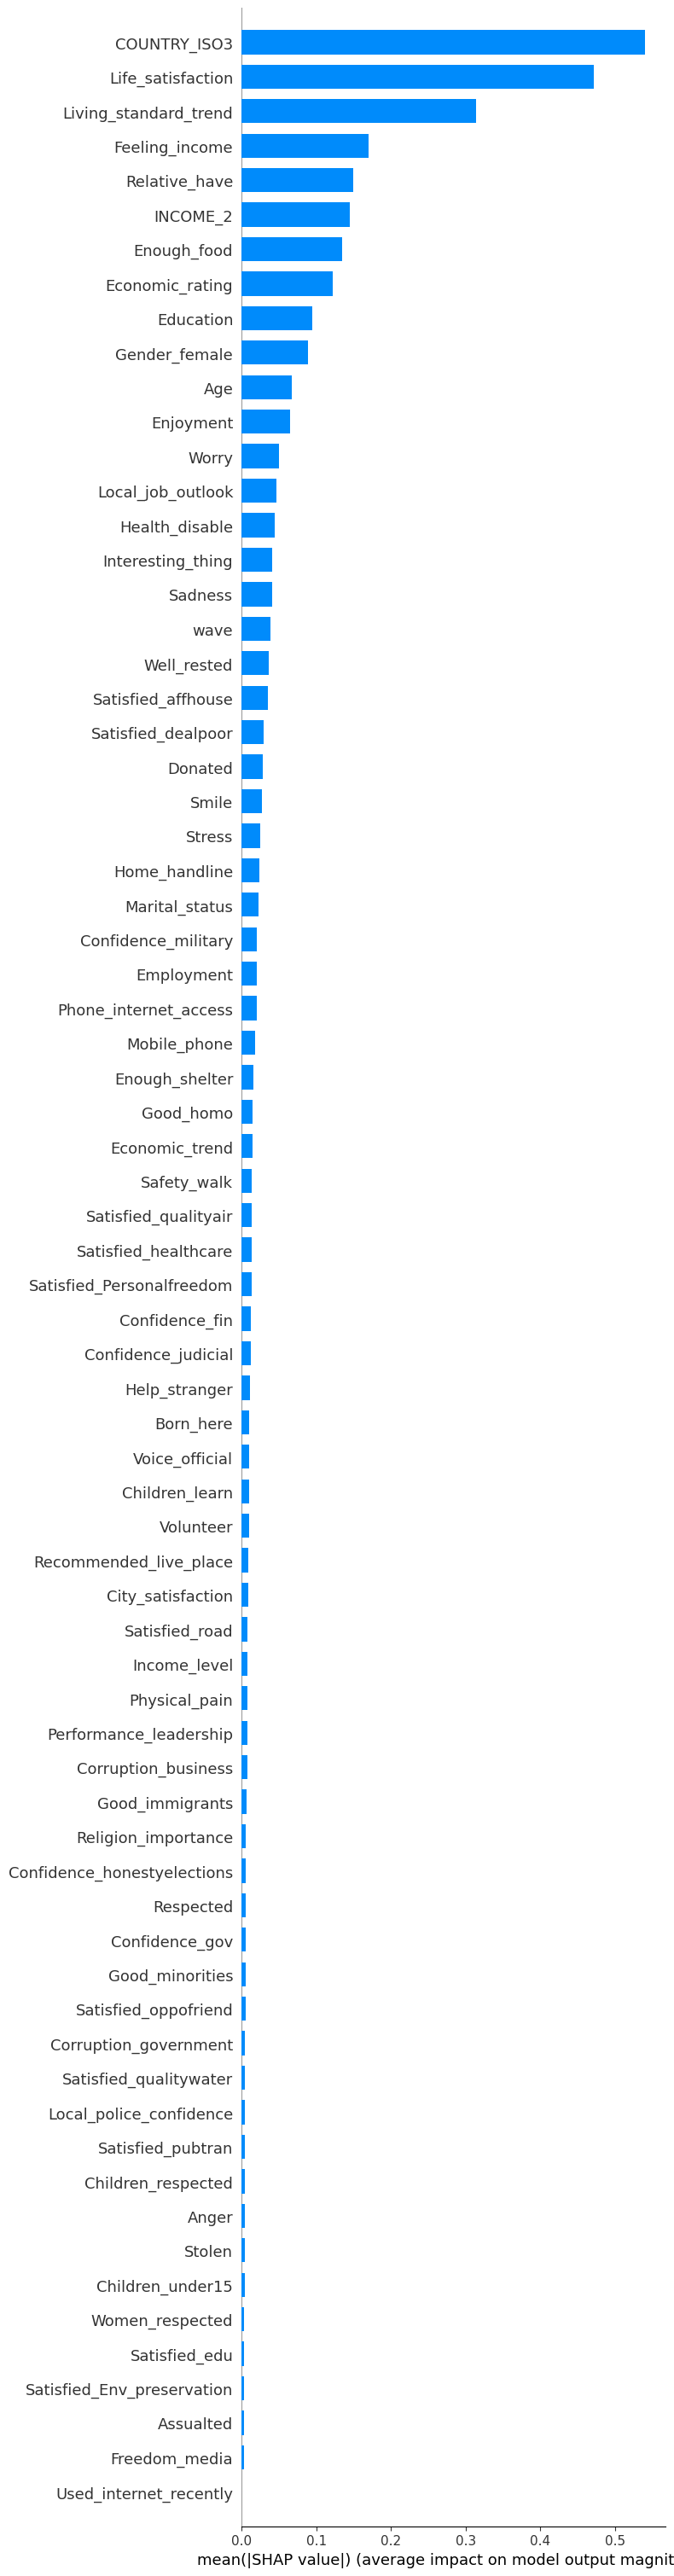

<Figure size 640x480 with 0 Axes>

In [48]:
# 生成显示所有特征的SHAP汇总图
plt.figure(figsize=(12, len(Xu.columns) * 0.3))  # 调整图表大小以适应所有特征
shap.summary_plot(shap_values, Xu, plot_type="bar", max_display=len(Xu.columns))
plt.tight_layout()

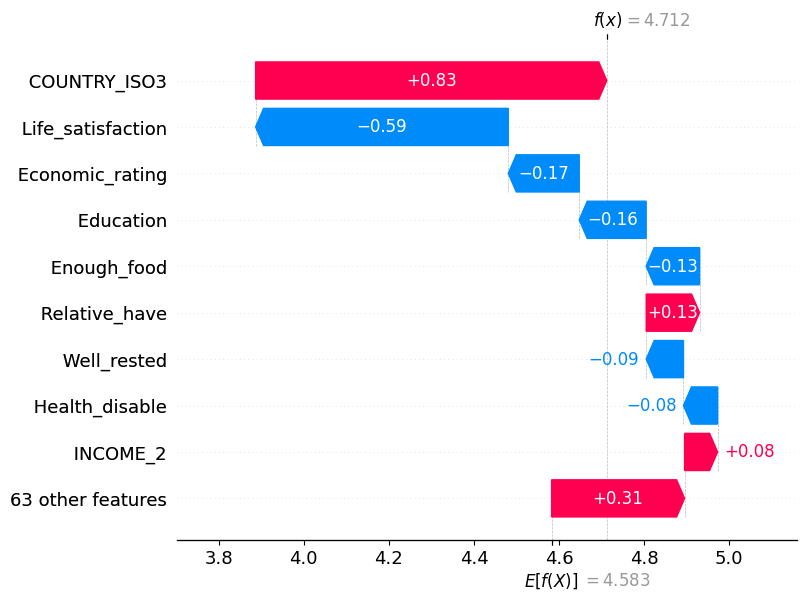

In [49]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], Xu.iloc[0], 
                                       feature_names=Xu.columns, max_display=10)

### Internet_Available Model

In [50]:
model = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                          n_estimators = 1000,  learning_rate = 0.01, max_depth = 10,   subsample = 0.8,
                                             gamma = 0, min_child_weight = 10, max_delta_step = 1,
                                             reg_lambda = 0.1, reg_alpha = 1,
                         random_state=42, enable_categorical=True  )
model.fit(Xa_train, ya_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
             max_depth=10, max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [51]:
ya_pred = model.predict(Xa_test)

In [52]:
r2_score(ya_test, ya_pred) * 100

35.60176341258116

In [53]:
ya_train_pred = model.predict(Xa_train)

In [54]:
r2_score(ya_train, ya_train_pred) * 100

50.29419560649879

In [55]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xa, check_additivity=False)

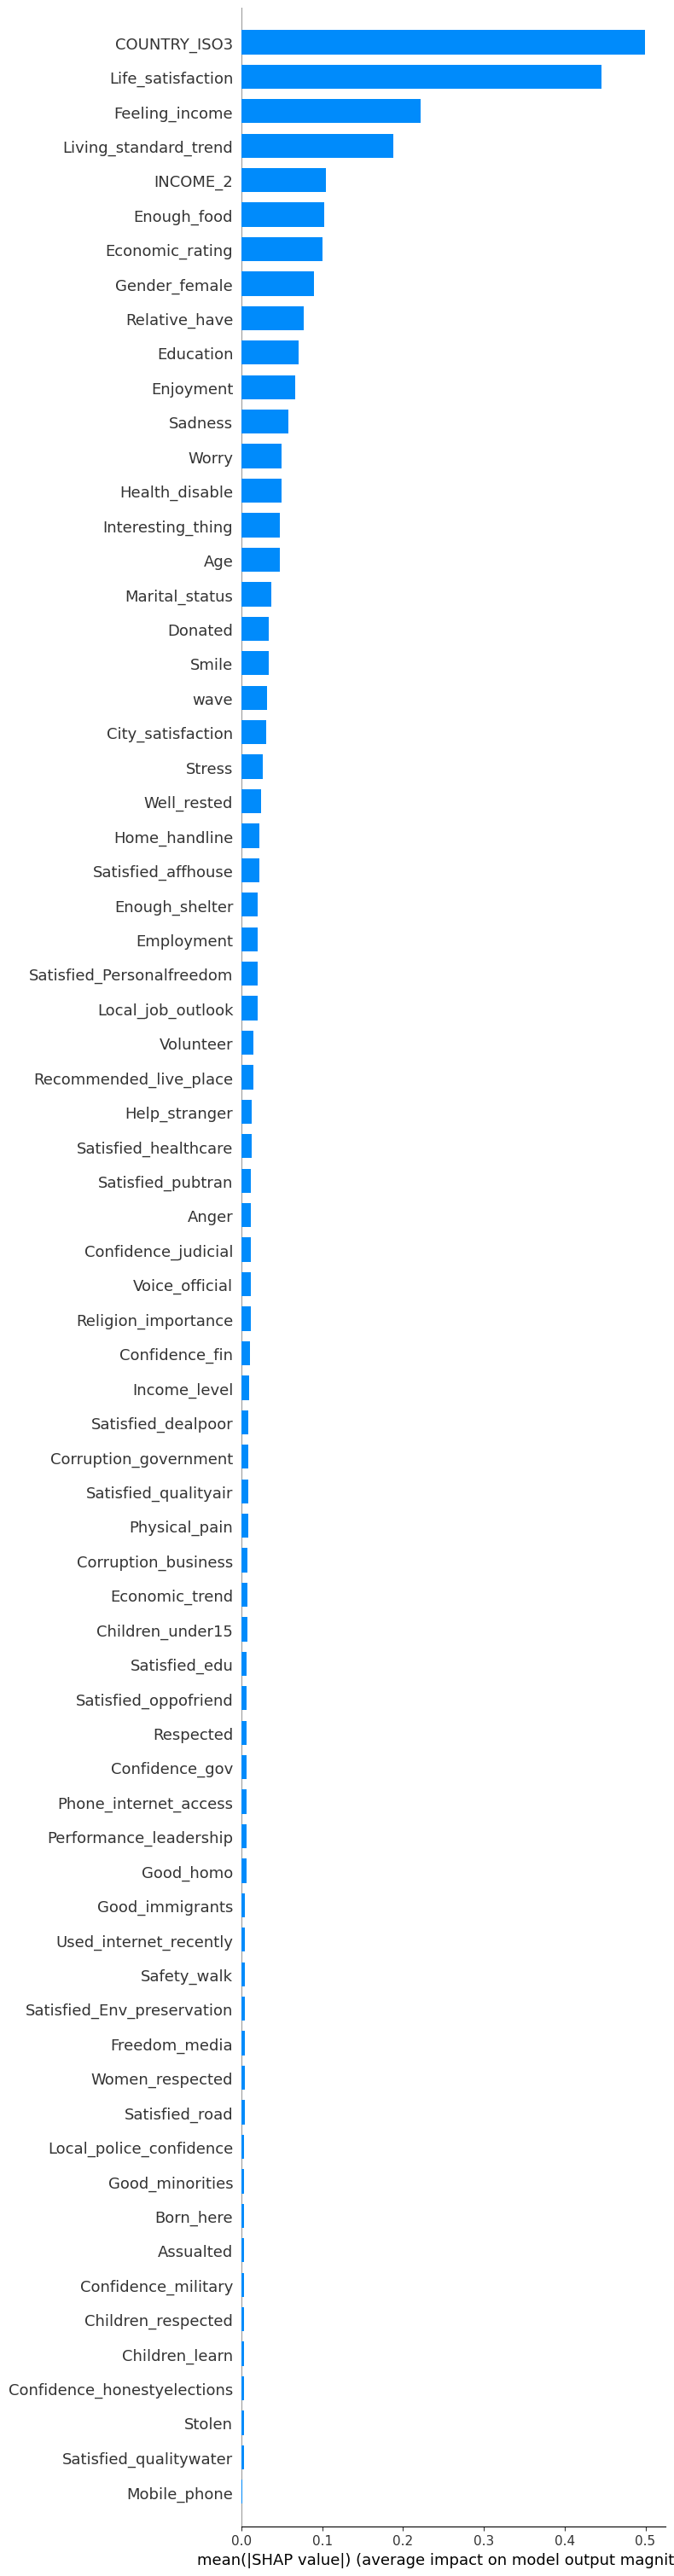

<Figure size 640x480 with 0 Axes>

In [56]:
# 生成显示所有特征的SHAP汇总图
plt.figure(figsize=(12, len(Xa.columns) * 0.3))  # 调整图表大小以适应所有特征
shap.summary_plot(shap_values, Xa, plot_type="bar", max_display=len(Xa.columns))
plt.tight_layout()

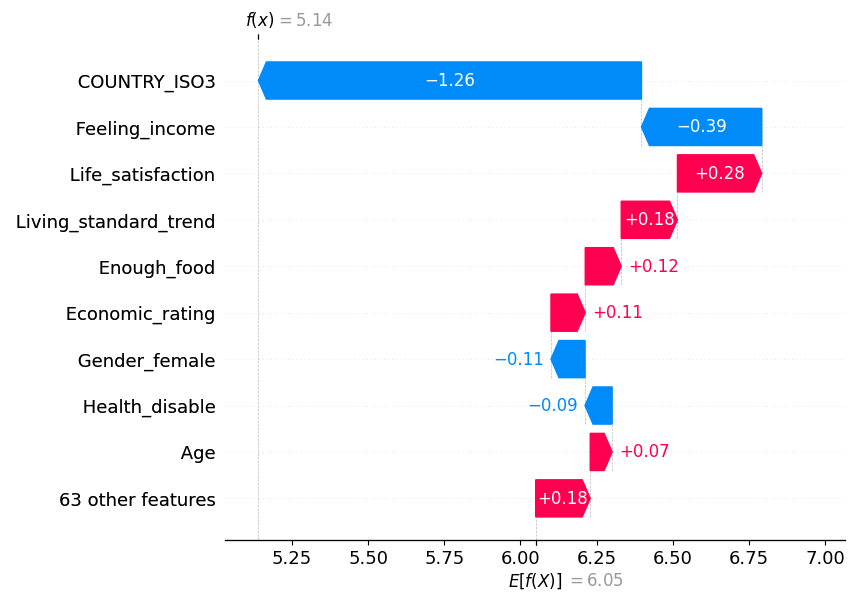

In [57]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], Xa.iloc[0], 
                                       feature_names=Xa.columns, max_display=10)

ValueError: could not convert string to float: 'EGY'

# SHAP One-hot version 

In [5]:
Df_Filename = os.path.join("Data", "GallupWB_Zhang47var798k6wave_v1.parquet")

In [6]:
Df = pd.read_parquet(Df_Filename)

In [7]:
Df.shape

(798604, 74)

In [8]:
Df.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,Children_under15,Feeling_income,Born_here,Home_handline,Mobile_phone,Internet_access_available,Used_internet_recently,Phone_internet_access,COUNTRY_ISO3,Income_level
1709734,12,592300.098717,5.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,5.0
1709735,12,106614.017769,9.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709736,12,21322.803554,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,USA,3.0
1709737,12,56860.809477,5.0,0.0,1.0,1.0,-0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709738,12,33844.027641,7.0,1.0,1.0,1.0,-0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,2.0


In [9]:
Df.columns

Index(['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have',
       'Life_satisfaction', 'Living_standard_trend', 'Enough_food',
       'Enough_shelter', 'Well_rested', 'Respected', 'Smile',
       'Interesting_thing', 'Enjoyment', 'Physical_pain', 'Worry', 'Sadness',
       'Stress', 'Anger', 'City_satisfaction', 'Recommended_live_place',
       'Economic_rating', 'Economic_trend', 'Local_job_outlook',
       'Satisfied_pubtran', 'Satisfied_road', 'Satisfied_edu',
       'Satisfied_qualityair', 'Satisfied_qualitywater',
       'Satisfied_healthcare', 'Satisfied_affhouse', 'Satisfied_oppofriend',
       'Good_minorities', 'Good_homo', 'Good_immigrants', 'Donated',
       'Volunteer', 'Help_stranger', 'Voice_official',
       'Local_police_confidence', 'Safety_walk', 'Stolen', 'Assualted',
       'Religion_importance', 'Children_respected', 'Children_learn',
       'Women_respected', 'Satisfied_dealpoor', 'Satisfied_Env_preservation',
       'Satisfied_Personalfreedom

### Shuffle Conversion

In [10]:
print(Df['COUNTRY_ISO3'].isnull().sum())

0


In [11]:
print(Df['COUNTRY_ISO3'].dtype)

object


In [12]:
# 对 COUNTRY_ISO3 进行 one-hot 编码
onehot_encoder = OneHotEncoder(sparse_output=False, dtype=int)
country_encoded = onehot_encoder.fit_transform(Df[['COUNTRY_ISO3']])
country_columns = onehot_encoder.get_feature_names_out(['COUNTRY_ISO3'])

# 创建一个新的 DataFrame，包含 one-hot 编码后的国家列
country_df = pd.DataFrame(country_encoded, columns=country_columns, index=Df.index)


In [13]:
# 检查 country_df 中是否有 NaN 值
print("NaN values in country_df:", country_df.isnull().sum().sum())


NaN values in country_df: 0


In [14]:
# 将 one-hot 编码的结果与原始数据合并
Df_new = pd.concat([Df.drop('COUNTRY_ISO3', axis=1), country_df], axis=1)


In [15]:
# 检查合并后的数据集中是否有 NaN 值
print("NaN values in Df_new:", Df_new.isnull().sum().sum())

NaN values in Df_new: 0


In [16]:
Df_new = Df_new.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
Df_new.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,COUNTRY_ISO3_USA,COUNTRY_ISO3_UZB,COUNTRY_ISO3_VEN,COUNTRY_ISO3_VNM,COUNTRY_ISO3_XKX,COUNTRY_ISO3_XNC,COUNTRY_ISO3_YEM,COUNTRY_ISO3_ZAF,COUNTRY_ISO3_ZMB,COUNTRY_ISO3_ZWE
0,13,5278.624306,3.0,1.0,1.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,14,0.000000,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,14,5345.822529,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,17,10127.215850,5.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,16,7106.753699,6.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Df_Internet_Unavailable 

In [18]:
Df_Internet_Unavailable = Df_new.loc[Df_new['Internet_access_available']==0, :].drop(columns=['Internet_access_available'])

In [19]:
Df_Internet_Unavailable.shape

(258850, 223)

In [20]:
yu = Df_Internet_Unavailable['Cantril_ladder']

In [21]:
Xu = Df_Internet_Unavailable.drop(columns=['Cantril_ladder'])

In [22]:
Xu_train, Xu_test, yu_train, yu_test = train_test_split(Xu, yu, test_size=0.1, random_state=42)

### Df_Internet_Available 

In [23]:
Df_Internet_available = Df_new.loc[Df_new['Internet_access_available']==1, :].drop(columns=['Internet_access_available'])

In [24]:
Df_Internet_available.shape

(539754, 223)

In [25]:
ya = Df_Internet_available['Cantril_ladder']

In [26]:
Xa = Df_Internet_available.drop(columns=['Cantril_ladder'])

In [27]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=0.1, random_state=42)

## Old Model 

### Internet_Unavailable Model

In [41]:
model_u = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                         n_estimators = 900,  learning_rate = 0.01, max_depth = 8,   subsample = 0.7,
                         random_state=42, enable_categorical=True  )
model_u.fit(Xu_train, yu_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
yu_pred = model_u.predict(Xu_test)
r2_score(yu_test, yu_pred) * 100

24.522877642766893

In [43]:
yu_train_pred = model_u.predict(Xu_train)
r2_score(yu_train, yu_train_pred) * 100

30.84704901509474

In [44]:
explainer = shap.explainers.GPUTree(model_u, Xu_test)
shap_values = explainer(Xu_test)

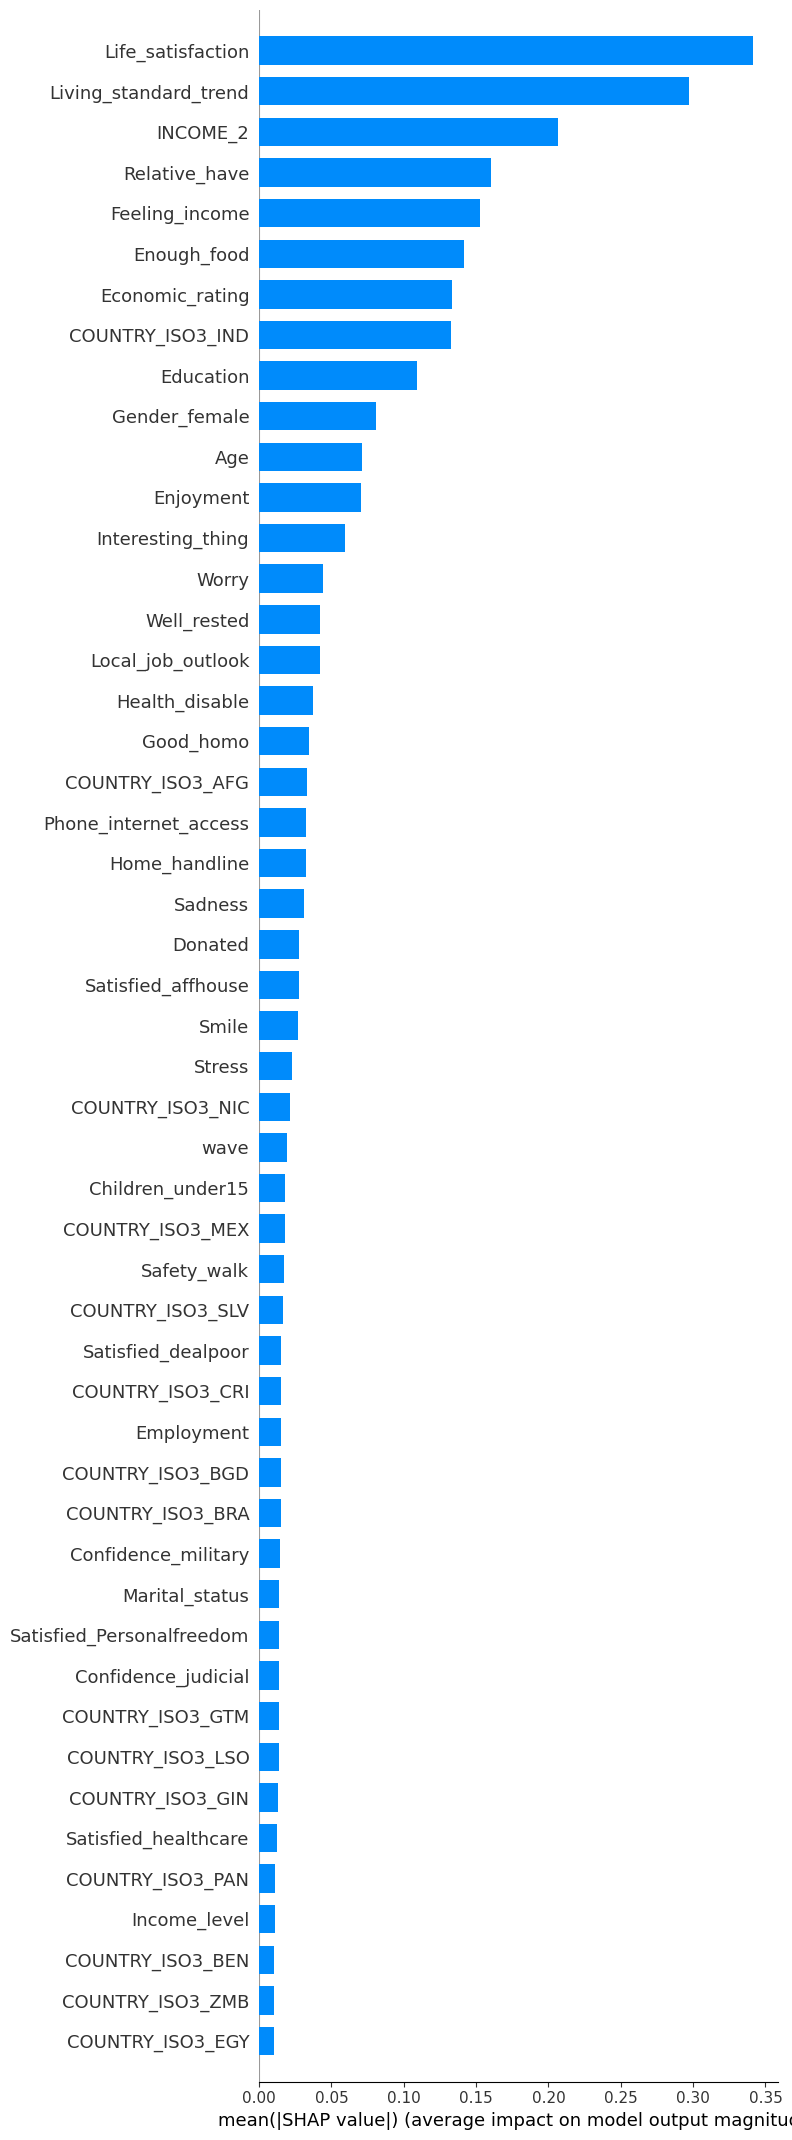

In [45]:
shap.summary_plot(shap_values, Xu_test, plot_type="bar", max_display=50)

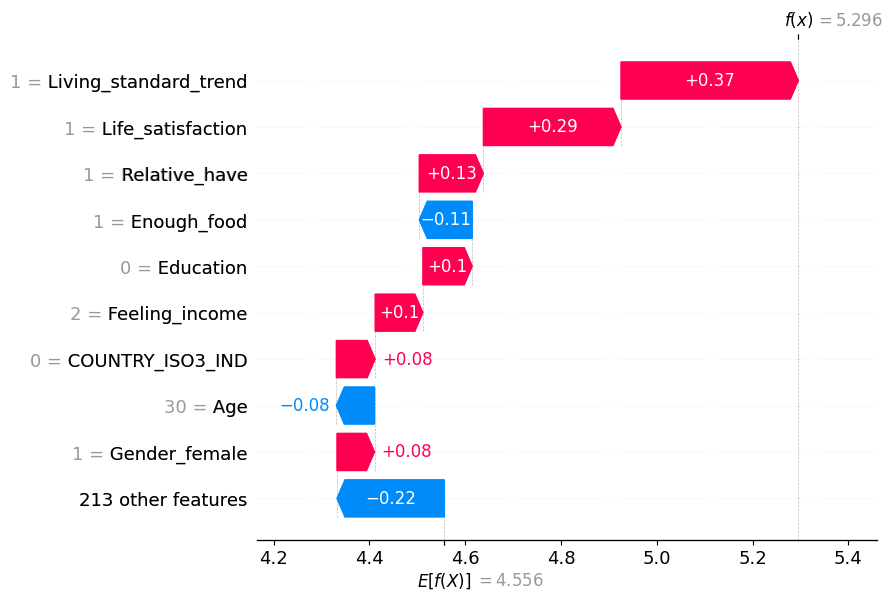

In [46]:
shap.plots.waterfall(shap_values[1])

### Internet_Available Model

In [47]:
model_a = xgb.XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', 
                          n_estimators = 1000,  learning_rate = 0.01, max_depth = 10,   subsample = 0.8,
                                             gamma = 0, min_child_weight = 10, max_delta_step = 1,
                                             reg_lambda = 0.1, reg_alpha = 1,
                         random_state=42, enable_categorical=True  )
model_a.fit(Xa_train, ya_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
             max_depth=10, max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [48]:
ya_pred = model_a.predict(Xa_test)

In [49]:
r2_score(ya_test, ya_pred) * 100

33.82902731738897

In [50]:
ya_train_pred = model_a.predict(Xa_train)

In [51]:
r2_score(ya_train, ya_train_pred) * 100

39.50452727014838

In [52]:
explainer = shap.explainers.GPUTree(model_a, Xu_test)
shap_values = explainer(Xu_test)

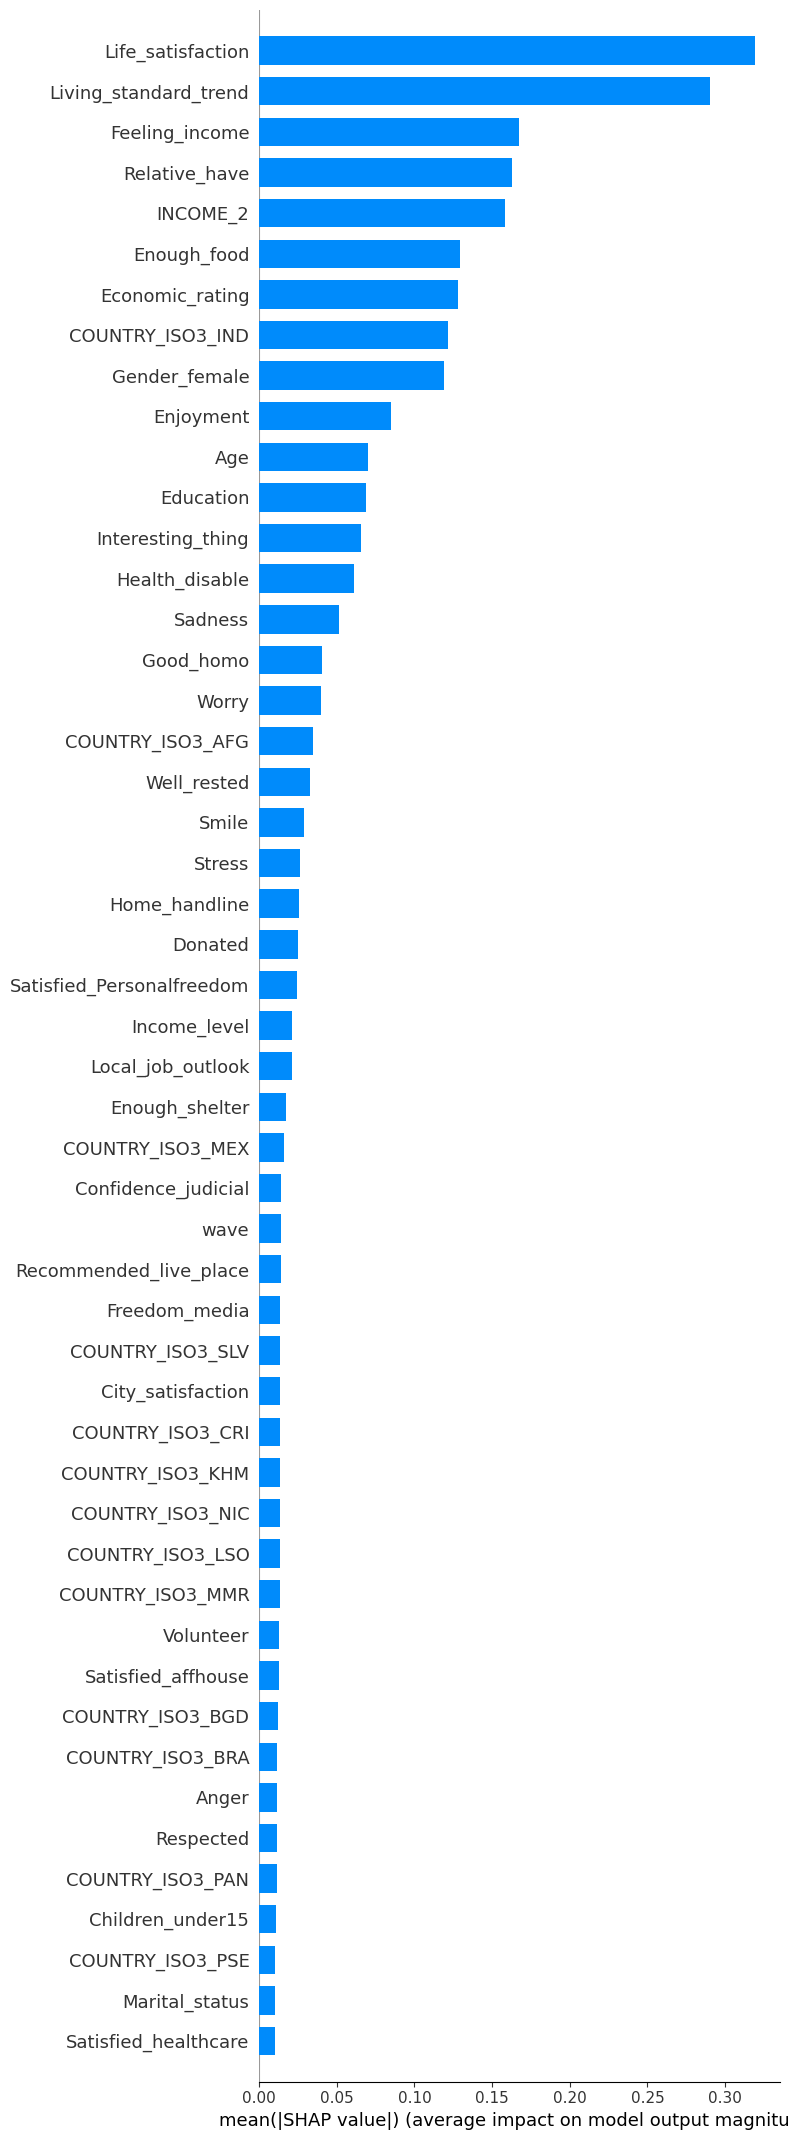

In [53]:
shap.summary_plot(shap_values, Xu_test, plot_type="bar", max_display=50)

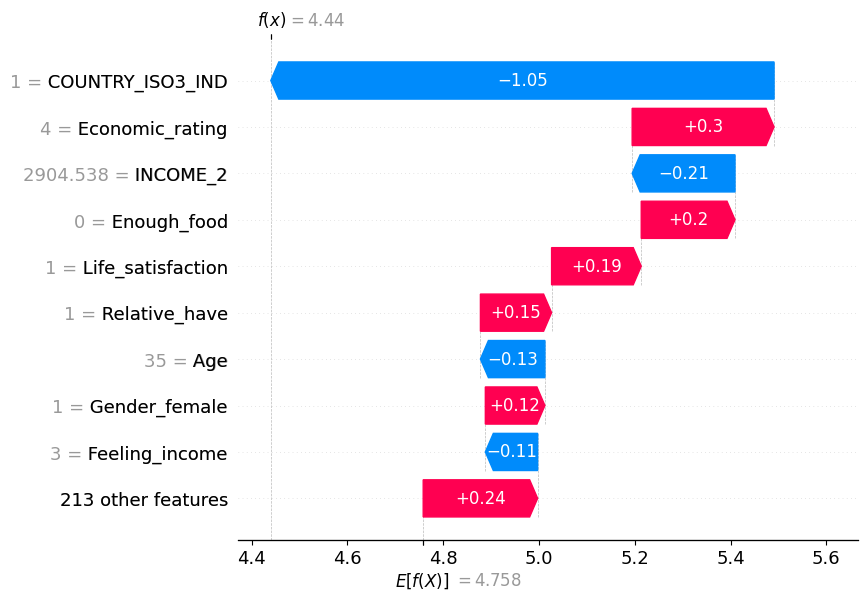

In [54]:
shap.plots.waterfall(shap_values[100])

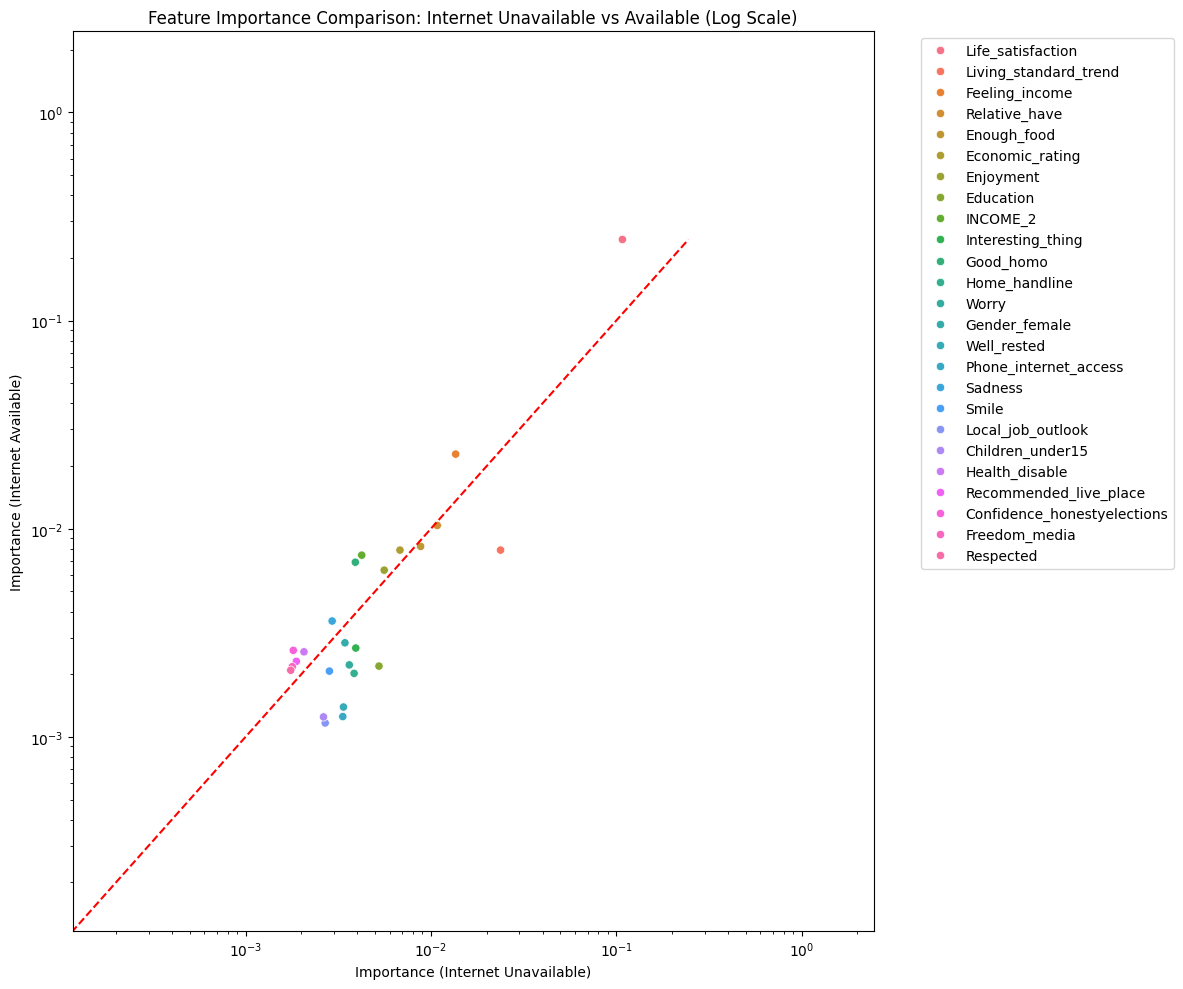

In [59]:
def get_feature_importance(model, X):
    importance = model.feature_importances_
    features = X.columns
    return pd.DataFrame({'feature': features, 'importance': importance}).sort_values('importance', ascending=False)

# 获取两个模型的特征重要性
importance_u = get_feature_importance(model_u, Xu)
importance_a = get_feature_importance(model_a, Xa)

# 合并两个DataFrame
importance_combined = importance_u.merge(importance_a, on='feature', suffixes=('_unavailable', '_available'))

# 过滤掉包含"COUNTRY_ISO3"的特征
importance_combined = importance_combined[~importance_combined['feature'].str.contains('COUNTRY_ISO3')]

# 选择top N个特征
N = 20
top_features = set(importance_combined.nlargest(N, 'importance_unavailable')['feature']) | set(importance_combined.nlargest(N, 'importance_available')['feature'])
importance_top = importance_combined[importance_combined['feature'].isin(top_features)]

# 创建对比图
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(data=importance_top, x='importance_unavailable', y='importance_available', hue='feature')

# 添加对角线
max_importance = max(importance_top['importance_unavailable'].max(), importance_top['importance_available'].max())
plt.plot([0, max_importance], [0, max_importance], 'r--')

# 调整坐标轴比例
plt.xscale('log')
plt.yscale('log')

# 设置坐标轴范围
min_importance = min(importance_top['importance_unavailable'].min(), importance_top['importance_available'].min())
plt.xlim(min_importance / 10, max_importance * 10)
plt.ylim(min_importance / 10, max_importance * 10)

plt.title('Feature Importance Comparison: Internet Unavailable vs Available (Log Scale)')
plt.xlabel('Importance (Internet Unavailable)')
plt.ylabel('Importance (Internet Available)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [60]:
# 计算重要性差异并展示
importance_top['importance_diff'] = importance_top['importance_available'] - importance_top['importance_unavailable']
importance_top = importance_top.sort_values('importance_diff', ascending=False)
print(importance_top[['feature', 'importance_unavailable', 'importance_available', 'importance_diff']])


                         feature  importance_unavailable  \
0              Life_satisfaction                0.107912   
3                 Feeling_income                0.013600   
80                      INCOME_2                0.004234   
93                     Good_homo                0.003910   
28               Economic_rating                0.006807   
178  Confidence_honestyelections                0.001809   
48                     Enjoyment                0.005596   
130                      Sadness                0.002932   
158               Health_disable                0.002066   
171       Recommended_live_place                0.001879   
180                Freedom_media                0.001787   
184                    Respected                0.001753   
5                  Relative_have                0.010822   
12                   Enough_food                0.008802   
111                Gender_female                0.003437   
134                        Smile        

/tmp/ipykernel_1729739/429915084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importance_top['importance_diff'] = importance_top['importance_available'] - importance_top['importance_unavailable']


/tmp/ipykernel_1729739/4184949185.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_top, x='importance_diff', y='feature', palette='coolwarm')


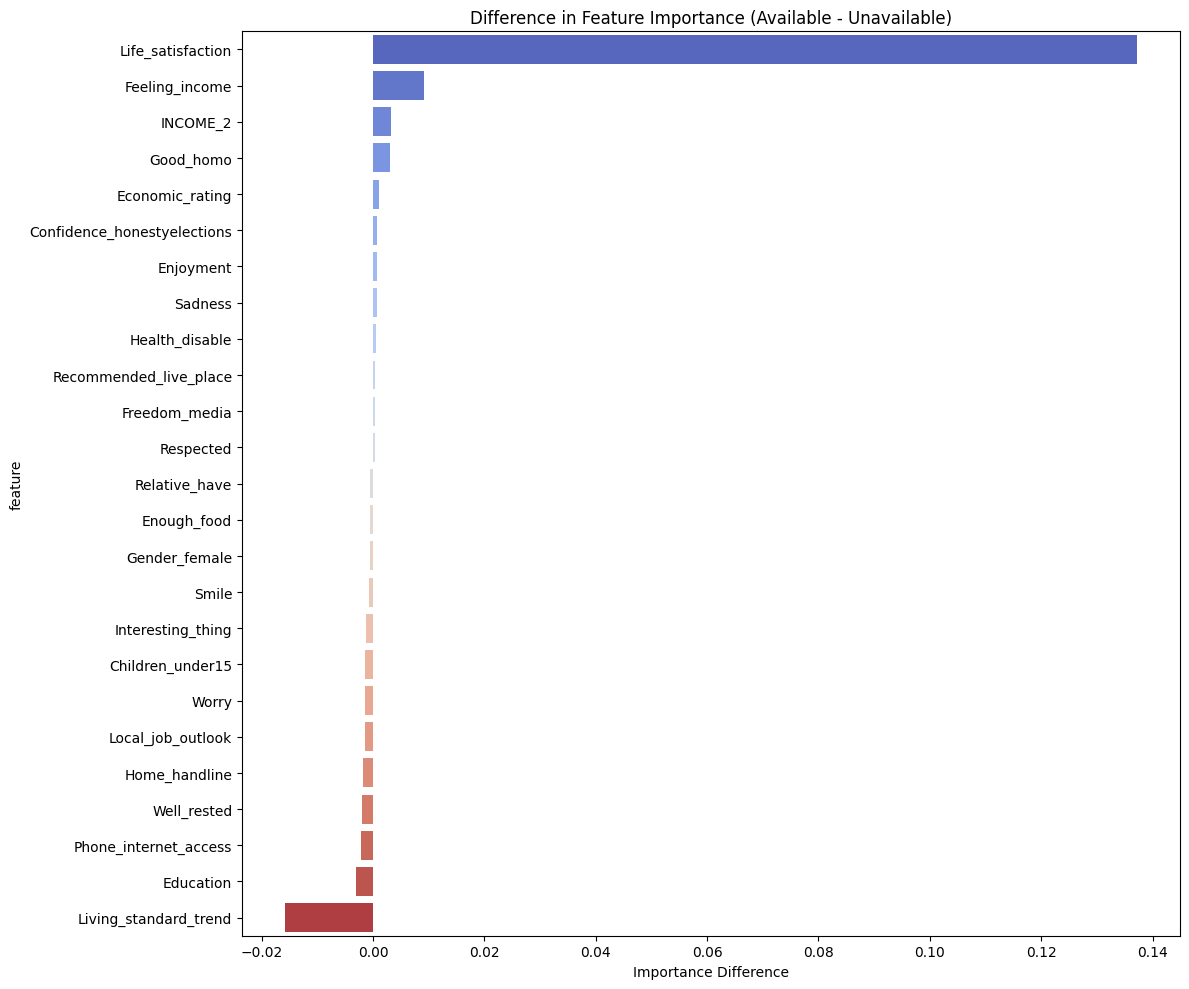

In [62]:

# 可视化重要性差异
plt.figure(figsize=(12, 10))
sns.barplot(data=importance_top, x='importance_diff', y='feature', palette='coolwarm')
plt.title('Difference in Feature Importance (Available - Unavailable)')
plt.xlabel('Importance Difference')
plt.tight_layout()
plt.show()

## PSM-XGBOOST

### Propensity Score

In [18]:
# 步骤1：估计倾向得分

In [19]:
# 1. 数据预处理：删除特定特征
features_to_remove = ['Used_internet_recently', 'Phone_internet_access']
Df_new = Df_new.drop(columns=features_to_remove)
# 2. 准备数据
X = Df_new.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
y = Df_new['Internet_access_available']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [20]:
# 3. 参数优化
def optimize_xgb_params(X_train, y_train):
    param_grid = {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3],
        'subsample': [0.8],
    }
    
    xgb_model = XGBClassifier(objective='binary:logistic', device = 'cuda', tree_method='hist', random_state=42)
    
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               cv=3, scoring='roc_auc', n_jobs=1, verbose=2)
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best ROC AUC score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

best_model = optimize_xgb_params(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:47:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.0s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.8s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.3s
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best ROC AUC score: 0.9093221506559894


In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [22]:
# 4. 评估最佳模型
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8405
Test ROC AUC: 0.9088


In [23]:
# 5. 估算倾向得分
def estimate_propensity_scores(df, model):
    X = df.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
    return model.predict_proba(X)[:, 1]

Df_new['propensity_score'] = estimate_propensity_scores(Df_new, best_model)


In [24]:
# 6. 打印倾向得分统计信息
print("\nPropensity Score Statistics:")
print(Df_new['propensity_score'].describe())

print("\nPropensity Score Statistics for Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'].describe())

print("\nPropensity Score Statistics for No Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'].describe())


Propensity Score Statistics:
count    798604.000000
mean          0.675907
std           0.308049
min           0.008755
25%           0.443681
50%           0.795498
75%           0.943583
max           0.994704
Name: propensity_score, dtype: float64

Propensity Score Statistics for Internet Access Group:
count    539754.000000
mean          0.825871
std           0.191530
min           0.014434
25%           0.754176
50%           0.902958
75%           0.964667
max           0.994704
Name: propensity_score, dtype: float64

Propensity Score Statistics for No Internet Access Group:
count    258850.000000
mean          0.363201
std           0.267571
min           0.008755
25%           0.124115
50%           0.305863
75%           0.576887
max           0.993119
Name: propensity_score, dtype: float64


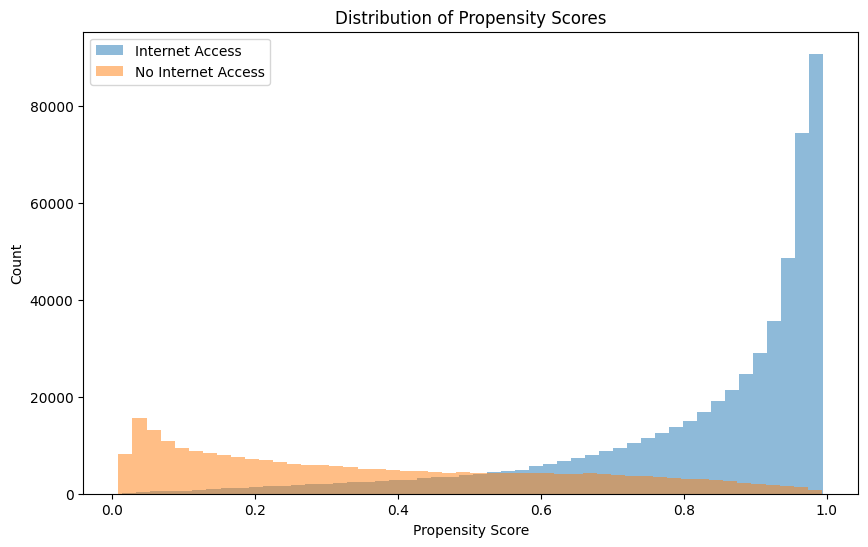

In [27]:
# 6. 可视化倾向得分分布
plt.figure(figsize=(10, 6))
plt.hist(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'], 
         bins=50, alpha=0.5, label='Internet Access')
plt.hist(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'], 
         bins=50, alpha=0.5, label='No Internet Access')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Propensity Scores')
plt.show()

In [32]:
from sklearn.neighbors import NearestNeighbors

In [33]:
# 8. 优化的样本匹配函数
def match_samples_optimized(df, caliper=0.2, n_jobs=-1):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    # 使用NearestNeighbors进行快速匹配
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean', n_jobs=n_jobs)
    nn.fit(control[['propensity_score']])
    
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    
    # 向量化操作进行匹配
    valid_matches = distances.flatten() < caliper
    
    matched_treated = treated[valid_matches]
    matched_control = control.iloc[indices.flatten()[valid_matches]]
    
    # 合并匹配结果
    matched_df = pd.concat([matched_treated, matched_control])
    
    return matched_df

matched_df = match_samples_optimized(Df_new)

In [34]:
# 8. 分组分析
def train_and_analyze(df, internet_access):
    subset = df[df['Internet_access_available'] == internet_access]
    X = subset.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
    y = subset['Cantril_ladder']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', n_estimators=1000, 
                         learning_rate=0.01, max_depth=6, subsample=0.8, 
                         random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared score for {'Internet Access' if internet_access else 'No Internet Access'}: {r2:.4f}")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    return model, shap_values, X_test


In [35]:
# 分别训练模型并获取SHAP值
model_with_internet, shap_values_with, X_test_with = train_and_analyze(matched_df, 1)
model_without_internet, shap_values_without, X_test_without = train_and_analyze(matched_df, 0)


R-squared score for Internet Access: 0.3276
R-squared score for No Internet Access: 0.4033


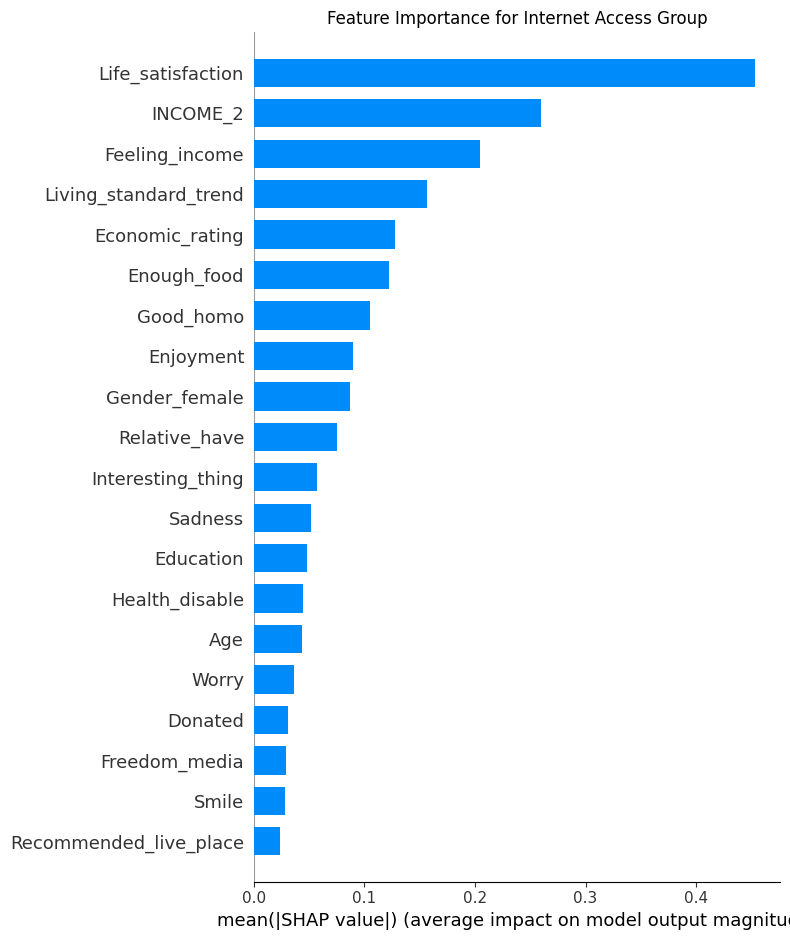

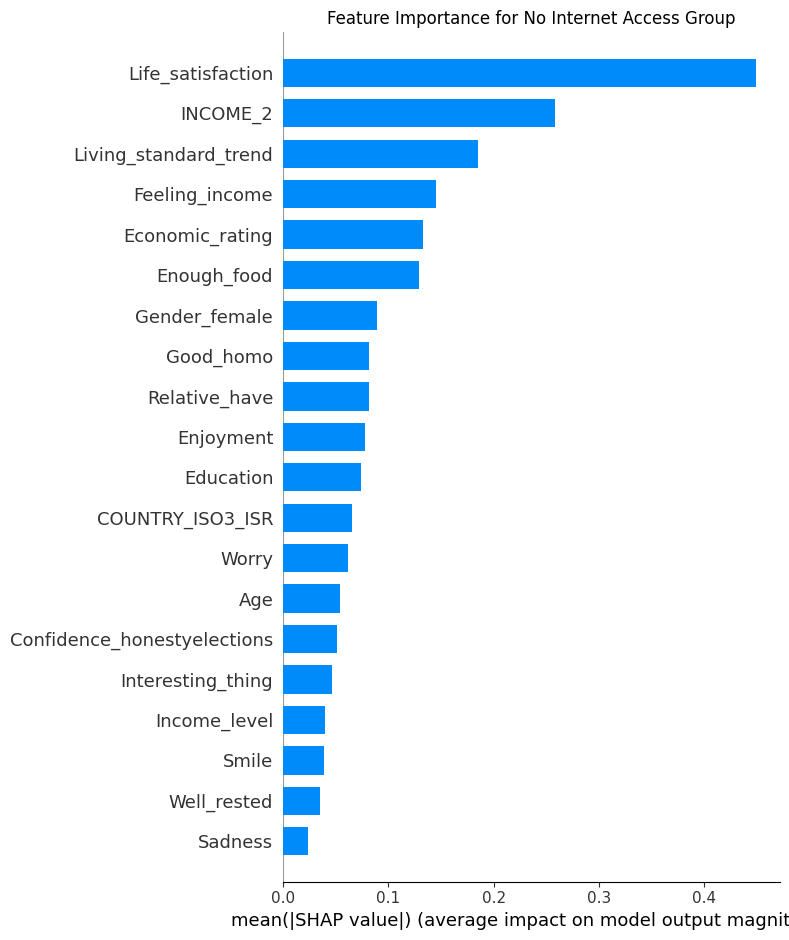

In [36]:
# 9. SHAP值分析
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_with, X_test_with, plot_type="bar", show=False)
plt.title("Feature Importance for Internet Access Group")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_without, X_test_without, plot_type="bar", show=False)
plt.title("Feature Importance for No Internet Access Group")
plt.tight_layout()
plt.show()


In [37]:
# 10. 比较变量影响
def compare_variable_impact(variable_name):
    impact_with = np.abs(shap_values_with[:, X_test_with.columns.get_loc(variable_name)]).mean()
    impact_without = np.abs(shap_values_without[:, X_test_without.columns.get_loc(variable_name)]).mean()
    
    print(f"Impact of {variable_name} on Cantril_ladder:")
    print(f"  With Internet Access: {impact_with:.4f}")
    print(f"  Without Internet Access: {impact_without:.4f}")
    print(f"  Difference: {impact_with - impact_without:.4f}")

variables_of_interest = ['INCOME_2', 'Education', 'Age', 'Employment', 'Health_disable', 'Life_satisfaction']
for var in variables_of_interest:
    compare_variable_impact(var)

Impact of INCOME_2 on Cantril_ladder:
  With Internet Access: 0.2599
  Without Internet Access: 0.2583
  Difference: 0.0015
Impact of Education on Cantril_ladder:
  With Internet Access: 0.0481
  Without Internet Access: 0.0740
  Difference: -0.0259
Impact of Age on Cantril_ladder:
  With Internet Access: 0.0438
  Without Internet Access: 0.0544
  Difference: -0.0107
Impact of Employment on Cantril_ladder:
  With Internet Access: 0.0013
  Without Internet Access: 0.0144
  Difference: -0.0131
Impact of Health_disable on Cantril_ladder:
  With Internet Access: 0.0444
  Without Internet Access: 0.0213
  Difference: 0.0231
Impact of Life_satisfaction on Cantril_ladder:
  With Internet Access: 0.4531
  Without Internet Access: 0.4493
  Difference: 0.0038


In [38]:
# 11. 估计互联网接入的总体影响
internet_effect = np.mean(matched_df[matched_df['Internet_access_available'] == 1]['Cantril_ladder']) - \
                  np.mean(matched_df[matched_df['Internet_access_available'] == 0]['Cantril_ladder'])
print(f"Estimated overall effect of internet access on Cantril_ladder: {internet_effect:.4f}")

Estimated overall effect of internet access on Cantril_ladder: 0.2162
